[[ 295987.85824991 2772907.96800037]
 [ 295987.85824991 2773060.54550037]
 [ 296150.60774991 2773060.54550037]
 [ 296150.60774991 2772907.96800037]]


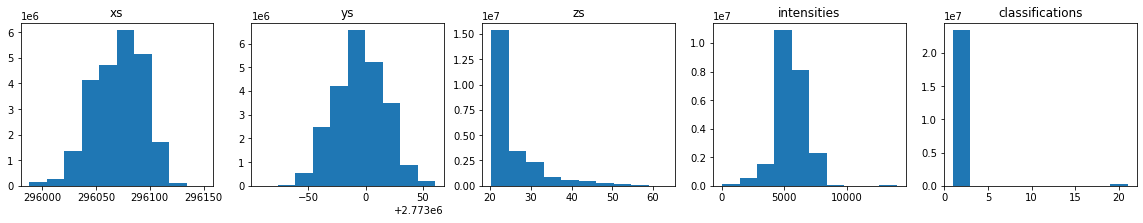

In [1]:
import os, shutil, subprocess
import laspy
import numpy as np
import pandas as pd
from TronGisPy import GisIO, CRS
from matplotlib import pyplot as plt
from sklearn.cluster import DBSCAN

class CloudPoint:
    def __init__(self, filepath, using_attr=["x", "y", "z", 
                                              "num_returns", "return_num", 
                                              "intensity", "classification", 
                                              "red", "green", "blue"]):
        self._filepath = filepath   
        self.using_attr = using_attr
        self.las_data, self.header = self._get_las_data()

    def __str__(self):
        return '{0.__class__.__name__}(filepath={0.filepath})'.format(self)

    @property
    def filepath(self):
        return self._filepath 
    
    @property
    def data(self):
        return self.las_data 
            
    def __getitem__(self,key):
        if type(key) is list:
            return np.array([self.las_data[k] for k in key]).T
        elif type(key) in [int, slice]:
            return np.array([self.las_data[k] for k in self.using_attr[key]]).T
        else:
            return self.las_data[key]
    
#     def __dir__(self):
#         print(f"Key of Cloud Point data")
#         return list(self.las_data.keys())


    def _get_las_data(self):
        """x, y, z, num_returns, return_num, intensity, classification, red, green, blue"""
        u_attr = self.using_attr
        with laspy.file.File(self._filepath, mode = "r") as lasFile:
            las_data = np.array([getattr(lasFile, i).copy() for i in u_attr]).T
            las_dict = {}
            for i in range(len(u_attr)):
                las_dict[u_attr[i]] = las_data[:, i]
            header = (lasFile.header.offset, lasFile.header.scale)
        return las_dict, header
    

    def plot_las_hist(self, plot=True, figsize=(15, 3)):
        fig, axes = plt.subplots(1,5, figsize=figsize)
        axes[0].hist(self.las_data["x"])
        axes[0].set_title("xs")
        axes[1].hist(self.las_data["y"])
        axes[1].set_title("ys")
        axes[2].hist(self.las_data["z"])
        axes[2].set_title("zs")
        axes[3].hist(self.las_data["intensity"])
        axes[3].set_title("intensities")
        axes[4].hist(self.las_data["classification"])
        axes[4].set_title("classifications")
        if plot:
            plt.show()
        return fig, axes
    
    def write_las_data(self, dst_filepath, scale=[1.0,1.0,1.0]):
        x, y, z = self.las_data["x"], self.las_data["y"], self.las_data["z"]
        num_returns, return_num = self.las_data["num_returns"], self.las_data["return_num"]        
        intensity, classification = self.las_data["intensity"], self.las_data["classification"]
        red, green, blue = self.las_data["red"], self.las_data["green"], self.las_data["blue"]
        offset = [np.floor(np.min(x)), np.floor(np.min(y)), np.floor(np.min(z))]

        outFile = laspy.file.File(dst_filepath, mode="w", header=laspy.header.Header(point_format=2)) # LAS point format 2 supports color
        outFile.header.offset, outFile.header.scale = self.header[0], self.header[1]

        outFile.x, outFile.y, outFile.z =x, y, z
        outFile.num_returns, outFile.return_num = num_returns.astype(np.int), return_num.astype(np.int)
        outFile.intensity = intensity
        outFile.classification = classification.astype(np.int)
        outFile.red, outFile.green, outFile.blue = red, green, blue
        outFile.close()
    
    def get_las_boundary(self, return_poly=True):
        
        xs, ys, zs = self.las_data["x"], self.las_data["y"], self.las_data["z"]
        x_min, x_max, y_min, y_max = np.min(xs), np.max(xs), np.min(ys), np.max(ys)
        if return_poly:
            return np.array([(x_min, y_min), (x_min, y_max), (x_max, y_max), (x_max, y_min)])
        else: 
            return (x_min, x_max, y_min, y_max)
        
    def convert_to_potree(self, page_name,
                          potree_converter_exe_path,
                          potree_web_path,
                          classification=True, overwrite=False):
        filepath = os.path.abspath(self.filepath)
        offset, scale = self.header
        assert os.path.isfile(filepath), filepath + " file does not exists."
        assert os.path.isfile(potree_converter_exe_path), potree_converter_exe_path + " file does not exists."
        assert offset != [0, 0, 0], "offset == [0, 0, 0] may takes long time to process."
        calls = "\"" + potree_converter_exe_path + "\"" + " " + os.path.abspath(filepath) + " -o " + "\"" + potree_web_path + "\"" + " --generate-page " + page_name
        if classification:
            calls += " --output-attributes RGB CLASSIFICATION"
        if overwrite:
            calls += " --overwrite"

        p = subprocess.Popen(calls, stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=True)
        out, err = p.communicate()
        if "ABORTING CONVERSION" in out.decode('cp950'):
            print('failed')
            print(out.decode('cp950'))
        else:
            print("success!!")

        return calls
    
    def proj_las_to_2D_plane(self, las_npidxs, X_ref, feature='z', operator='count'):
        """
        feature: should be in ['x', 'y', 'z', 'num_returns', 'return_num', 'intensity', 'classification', 'red', 'green', 'blue']
        operator: should be in ['max', 'min', 'count', 'std', 'mean', 'median', 'highest']
        """
        assert len(X_ref.shape) == 2, "X_ref should be two dimensional"
        X_canvas = np.full((X_ref.shape[0], X_ref.shape[1]), np.nan)
        x, y, z = self.las_data["x"], self.las_data["y"], self.las_data["z"]
        num_returns, return_num = self.las_data["num_returns"], self.las_data["return_num"]        
        intensity, classification = self.las_data["intensity"], self.las_data["classification"]
        red, green, blue = self.las_data["red"], self.las_data["green"], self.las_data["blue"]
        df_points = pd.DataFrame(las_npidxs, columns=['npidx_row', 'npidx_col'])
        df_points[feature] = eval(feature)
        if operator in ['max', 'min', 'count', 'std', 'mean', 'median']:
            df_points_grouped = eval("df_points.groupby(['npidx_row', 'npidx_col'])."+operator+"()['"+feature+"']")
            X_canvas_values = df_points_grouped.values
            unique_npidxs = np.array(df_points_grouped.index.tolist())
        X_canvas[unique_npidxs[:, 0], unique_npidxs[:, 1]] = X_canvas_values
        return X_canvas
    
        #eps=2, min_samples=1.7
        
    def density_cluster(self, eps=0.5, min_samples=5, metric='euclidean', 
                        metric_params=None,algorithm='auto', leaf_size=30, p=None, n_jobs=None):
        """Perform Density-Based Spatial Clustering of Applications with Noise from cloud point xyz.
        Finds core samples of high density and expands clusters from them.
        Parameters
        ----------
        eps : float, default=0.5
            The maximum distance between two samples for one to be considered
            as in the neighborhood of the other. This is not a maximum bound
            on the distances of points within a cluster. This is the most
            important DBSCAN parameter to choose appropriately for your data set
            and distance function.
        min_samples : int, default=5
            The number of samples (or total weight) in a neighborhood for a point
            to be considered as a core point. This includes the point itself.
        metric : string, or callable, default='euclidean'
            The metric to use when calculating distance between instances in a
            feature array. If metric is a string or callable, it must be one of
            the options allowed by :func:`sklearn.metrics.pairwise_distances` for
            its metric parameter.
            If metric is "precomputed", X is assumed to be a distance matrix and
            must be square. X may be a :term:`Glossary <sparse graph>`, in which
            case only "nonzero" elements may be considered neighbors for DBSCAN.
            .. versionadded:: 0.17
               metric *precomputed* to accept precomputed sparse matrix.
        metric_params : dict, default=None
            Additional keyword arguments for the metric function.
            .. versionadded:: 0.19
        algorithm : {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'
            The algorithm to be used by the NearestNeighbors module
            to compute pointwise distances and find nearest neighbors.
            See NearestNeighbors module documentation for details.
        leaf_size : int, default=30
            Leaf size passed to BallTree or cKDTree. This can affect the speed
            of the construction and query, as well as the memory required
            to store the tree. The optimal value depends
            on the nature of the problem.
        p : float, default=None
            The power of the Minkowski metric to be used to calculate distance
            between points.
        n_jobs : int or None, default=None
            The number of parallel jobs to run.
            ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
            ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
            for more details.
        Attributes
        ----------
        core_sample_indices_ : array, shape = [n_core_samples]
            Indices of core samples.
        components_ : array, shape = [n_core_samples, n_features]
            Copy of each core sample found by training.
        labels_ : array, shape = [n_samples]
            Cluster labels for each point in the dataset given to fit().
            Noisy samples are given the label -1.
        """
        xyz = np.array([self.las_data[i] for i in ["x", "y", "z"]]).T
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric=metric, metric_params=metric_params,algorithm=algorithm, leaf_size=leaf_size, p=p, n_jobs=n_jobs)
        dbscan = dbscan.fit(xyz)
        clusters = dbscan.labels_
        return clusters
    
def draw_rgb(las_src, las_dst, X_rgb, geo_transform, verbose=True):
    inFile = laspy.file.File(las_src, mode = "r")
    outFile = laspy.file.File(las_dst, mode="w", header=laspy.header.Header(point_format=2)) # LAS point format 2 supports color

    # header
    outFile.header.offset = inFile.header.offset
    outFile.header.scale = inFile.header.scale
    
    # attribute
    outFile.intensity = inFile.intensity
    outFile.x, outFile.y, outFile.z = inFile.x, inFile.y, inFile.z
    outFile.num_returns = inFile.num_returns
    outFile.return_num = inFile.return_num
    outFile.classification = inFile.classification
    
    # rgb
    las_coords = np.array([outFile.x.copy(), outFile.y.copy()]).T
    las_npidxs = np.array(CRS.numba_transfer_group_coord_to_npidx(las_coords, geo_transform)).astype(np.int)
    X_rgb, las_npidxs = pad_rgb(X_rgb, las_npidxs, verbose=verbose)
    outFile.red, outFile.green, outFile.blue, _ = X_rgb[las_npidxs[:,0], las_npidxs[:,1]].T
    inFile.close(), outFile.close()
    
def pad_rgb(X_rgb, las_npidxs, verbose=True):
    npidx_row_gt_bounds = np.max(las_npidxs[:,0]) - (X_rgb.shape[0]-1)
    npidx_col_gt_bounds = np.max(las_npidxs[:,1]) - (X_rgb.shape[1]-1)
    npidx_row_lt_bounds = -np.min(las_npidxs[:,0])
    npidx_col_lt_bounds = -np.min(las_npidxs[:,1])
    if npidx_row_gt_bounds > 0:
        if verbose: print("npidx_row_gt_bounds", npidx_row_gt_bounds)
        X_rgb = np.pad(X_rgb, ((0, npidx_row_gt_bounds), (0, 0), (0, 0)), mode='edge')
    if npidx_col_gt_bounds > 0:
        if verbose: print("npidx_col_gt_bounds", npidx_col_gt_bounds)
        X_rgb = np.pad(X_rgb, ((0, 0), (0, npidx_col_gt_bounds), (0, 0)), mode='edge')
    if npidx_row_lt_bounds > 0:
        if verbose: print("npidx_row_lt_bounds", npidx_row_lt_bounds)
        X_rgb = np.pad(X_rgb, ((npidx_row_lt_bounds, 0), (0, 0), (0, 0)), mode='edge')
        las_npidxs[:,0] += npidx_row_lt_bounds
    if npidx_col_lt_bounds > 0:
        if verbose: print("npidx_col_lt_bounds", npidx_col_lt_bounds)
        X_rgb = np.pad(X_rgb, ((0, 0), (npidx_col_lt_bounds, 0), (0, 0)), mode='edge')
        las_npidxs[:,1] += npidx_col_lt_bounds
    return X_rgb, las_npidxs

def draw_profile(las_data, las_npidxs, las_rgbs, X_rgb, X_rgb_extent, row_npidx,
                 width=5, s=0.5, df_las_boundry=None, coors_lng_lim=None, height_lim=None):
    coord_lat_st = las_data[:, 1][row_npidx==las_npidxs[:,0]][0]
    mask = np.isin(las_npidxs[:, 0], range(row_npidx, row_npidx+width))
    xs_sliced, ys_sliced, zs_sliced = las_data[mask][:, :3].T
    rgbs_sliced = las_rgbs[np.where(mask)]

    fig = plt.figure(figsize=(30, 6))
    gs = fig.add_gridspec(1,6)
    ax1, ax2 = fig.add_subplot(gs[0, :2]), fig.add_subplot(gs[0, 2:])
    ax1.imshow(X_rgb, extent=X_rgb_extent)
    ax1.axhline(y=coord_lat_st)
    if df_las_boundry:
        df_las_boundry.boundary.plot(ax=ax1)

    ax2.scatter(xs_sliced, zs_sliced, c=rgbs_sliced.tolist(), s=s)
    if height_lim is not None:
        ax2.set_ylim(height_lim)
    
    if coors_lng_lim is not None:
        coors_lng_st, coors_lng_end = coors_lng_lim
        ax1.axvline(x=coors_lng_st)
        ax1.axvline(x=coors_lng_end)
        ax2.set_xlim([coors_lng_st, coors_lng_end])
    plt.show()

def las_composition(filepaths, dst_filepath):
    # reading file
    inFile = laspy.file.File(filepaths[0], mode = "r")
    las_offset, las_scale = inFile.header.offset, inFile.header.scale
    las_data = [get_las_data(filepath) for filepath in filepaths]
    las_data = np.concatenate(las_data, axis=0)
    x, y, z, num_returns, return_num, intensity, classification, red, green, blue = las_data.T
    las_offset = [np.floor(np.min(x)), np.floor(np.min(y)), np.floor(np.min(z))]

    # writing file
    outFile = laspy.file.File(dst_filepath, mode="w",
                              header=laspy.header.Header(point_format=2)) # LAS point format 2 supports color
    outFile.header.offset = las_offset
    outFile.header.scale = las_scale
    outFile.x, outFile.y, outFile.z = x.copy(), y.copy(), z.copy()
    outFile.num_returns = num_returns.copy().astype(np.int)
    outFile.return_num = return_num.copy().astype(np.int)
    outFile.intensity = intensity.copy()
    outFile.classification = classification.copy().astype(np.int)
    outFile.red, outFile.green, outFile.blue = red.copy(), green.copy(), blue.copy()
    outFile.close()

las_fp = os.path.join("data", "123.las")
tmp = CloudPoint(las_fp)
fig_1, ax_1 = tmp.plot_las_hist(plot=False, figsize=(20,3))
print(tmp.get_las_boundary())

In [4]:
%%time
tmp.write_las_data("tmp/las_test_out.las") # Wall time: 19.4 s

Wall time: 19.4 s


In [5]:
%%time 
tmp.convert_to_potree("CloudPointTestPage", 
                      r"C:\PotreeConverter\PotreeConverter.exe", 
                      r"C:\Program Files\xampp\htdocs\potree") # Wall time: 46.7 s


success!!
Wall time: 46.7 s


'"C:\\PotreeConverter\\PotreeConverter.exe" C:\\Users\\TTL_R041\\Desktop\\Projects\\RS2001\\LineDetection\\data\\123.las -o "C:\\Program Files\\xampp\\htdocs\\potree" --generate-page CloudPointTestPage --output-attributes RGB CLASSIFICATION'

In [3]:
%%time

tmp.density_cluster(eps=4, min_samples=5)

MemoryError: 